In [15]:
print('Setting UP')
import os

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.python.keras.callbacks import EarlyStopping
from utils import *
%matplotlib inline

Setting UP


In [16]:
batch_data_size = 24  
# steering_mapping = {'forward': 0, 'left': 1, 'right': 2}
image_data_directory = 'data_collected'

In [17]:
image_dataframe = import_data(image_data_directory)
print(image_dataframe.shape)
print(image_dataframe.head())

10:8611:7912:8313:7314:8115:8016:8017:7718:8119:7920:7921:81total imported images 959
(959, 2)
                             Center Steering
0  IMG10/Image_1716802417094264.jpg     left
1  IMG10/Image_1716802418141973.jpg  forward
2  IMG10/Image_1716802419189981.jpg  forward
3  IMG10/Image_1716802420216215.jpg  forward
4  IMG10/Image_1716802421248789.jpg  forward


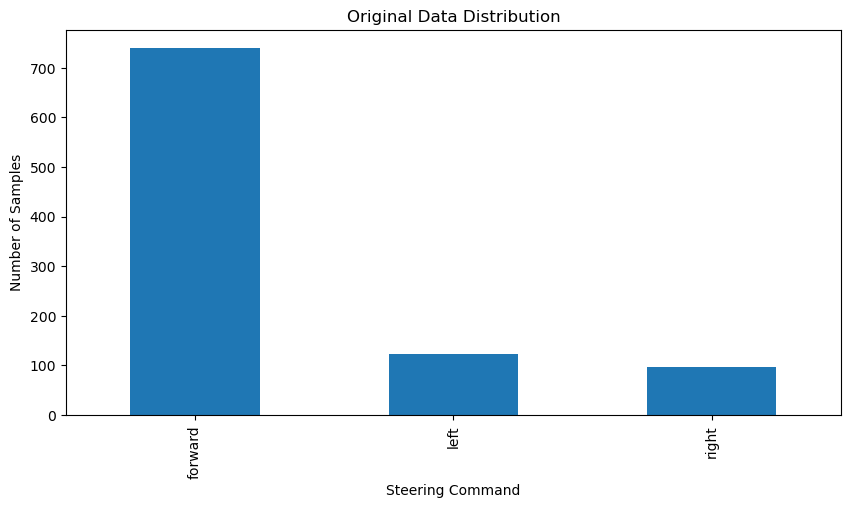

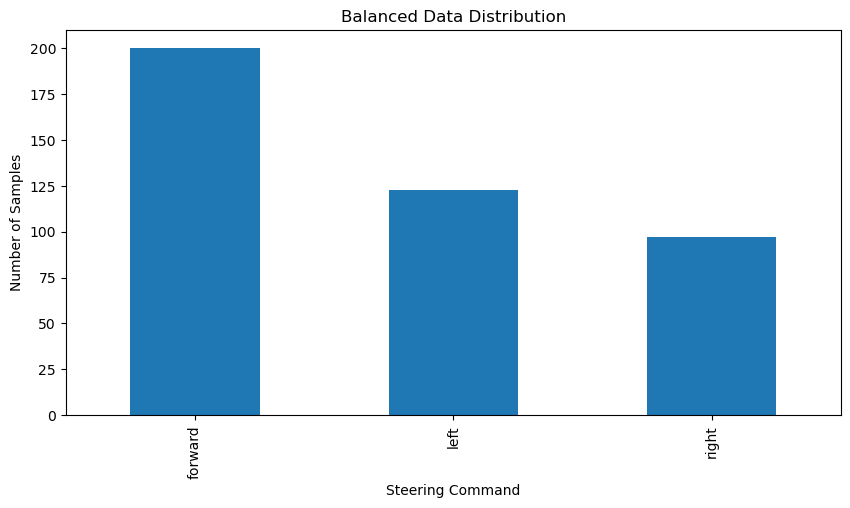

Removed Images: 539
Remaining Images: 420
                              Center Steering  Steering_forward  \
0   IMG10/Image_1716802417094264.jpg     left               0.0   
1   IMG10/Image_1716802418141973.jpg  forward               1.0   
5   IMG10/Image_1716802422276296.jpg     left               0.0   
10  IMG10/Image_1716802427461581.jpg     left               0.0   
11   IMG10/Image_171680242853871.jpg     left               0.0   

    Steering_left  Steering_right  
0             1.0             0.0  
1             0.0             0.0  
5             1.0             0.0  
10            1.0             0.0  
11            1.0             0.0  


In [18]:
# balance data
image_dataframe = balance_data(image_dataframe, display=True)  # vis and balance
print(image_dataframe.head())

In [19]:
# preprocess
images_path, steering, steering_forward, steering_left, steering_right = load_data(
    image_data_directory,
    image_dataframe)

print(f' image_path :: {len(images_path)} steering :: {len(steering)} steering_forward :: {len(steering_forward)} '
      f'steering_left :: {len(steering_left)} steering_right {len(steering_right)}')

 image_path :: 420 steering :: 420 steering_forward :: 420 steering_left :: 420 steering_right 420


In [20]:
# split: validation and train setup
data_frame = pd.DataFrame({
      'images_path': images_path,
      'steering': steering,
      'steering_forward': steering_forward,
      'steering_left': steering_left,
      'steering_right': steering_right
})

X = data_frame[['images_path', 'steering_forward', 'steering_left', 'steering_right']]
y = data_frame[['steering_forward', 'steering_left', 'steering_right']]

print(X.head())


                                       images_path  steering_forward  \
0  data_collected/IMG10/Image_1716802417094264.jpg               0.0   
1  data_collected/IMG10/Image_1716802418141973.jpg               1.0   
2  data_collected/IMG10/Image_1716802422276296.jpg               0.0   
3  data_collected/IMG10/Image_1716802427461581.jpg               0.0   
4   data_collected/IMG10/Image_171680242853871.jpg               0.0   

   steering_left  steering_right  
0            1.0             0.0  
1            0.0             0.0  
2            1.0             0.0  
3            1.0             0.0  
4            1.0             0.0  


In [21]:
xTrain, xVal, yTrain, yVal = train_test_split(
      X,
      y,
      test_size=0.2,
      random_state=10
)
print(f'total training Images: {len(xTrain)}')
print(f'total validation Images: {len(xVal)}')

total training Images: 336
total validation Images: 84


In [22]:
# data generators (training and validation)
train_generator = tf.data.Dataset.from_generator(
    lambda: data_generator(
        xTrain['images_path'].values,
        xTrain['steering_forward'].values,
        xTrain['steering_left'].values,
        xTrain['steering_right'].values,
        batch_size=batch_data_size,
        train_flag=True
    ),
    output_signature=(
        {
            'image_input': tf.TensorSpec(shape=(None, 66, 200, 3), dtype=tf.float32),
            'numerical_input': tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
    )
)

validation_generator = tf.data.Dataset.from_generator(
    lambda: data_generator(
        xVal['images_path'].values,
        xVal['steering_forward'].values,
        xVal['steering_left'].values,
        xVal['steering_right'].values,
        batch_size=batch_data_size,
        train_flag=False
    ),
    output_signature=(
        {
            'image_input': tf.TensorSpec(shape=(None, 66, 200, 3), dtype=tf.float32),
            'numerical_input': tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
    )
)

In [23]:
# model
model = create_model()
print(model.summary())

# we have more forwards
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(yTrain, axis=1)),
    y=np.argmax(yTrain, axis=1)
)
class_weights_dictionary = {i: class_weights[i] for i in range(len(class_weights))}
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 66, 200,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 31, 98,    │      1,824 │ image_input[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 14, 47,    │     21,636 │ conv2d_5[0][0]    │
│                     │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 5, 22, 48) │     43,248 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 3, 20, 64) │     27,712 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 1, 18, 64) │     36,928 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1152)      │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 100)       │    115,300 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │        128 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 50)        │      5,050 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 16)        │        528 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10)        │        510 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 8)         │        136 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 18)        │          0 │ dense_11[0][0],   │
│ (Concatenate)       │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 50)        │        950 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 10)        │        510 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         11 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 254,471 (994.03 KB)

 Trainable params: 254,471 (994.03 KB)

 Non-trainable params: 0 (0.00 B)

None


In [24]:
# train
history = model.fit(
    train_generator,
    steps_per_epoch=len(xTrain) // batch_data_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(xVal) // batch_data_size,
    class_weight=class_weights_dictionary,
    callbacks=[early_stopping]
)
model.save('model.keras')
print('Model Saved')


Epoch 1/10


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - loss: 0.3836 - mae: 0.4964 - mse: 0.4697 - val_loss: 0.3942 - val_mae: 0.4148 - val_mse: 0.3942
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - loss: 0.4011 - mae: 0.3919 - mse: 0.3762 - val_loss: 0.3704 - val_mae: 0.3849 - val_mse: 0.3704
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 0.3327 - mae: 0.3643 - mse: 0.3551 - val_loss: 0.3287 - val_mae: 0.3357 - val_mse: 0.3287
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 0.2516 - mae: 0.3368 - mse: 0.3271 - val_loss: 0.3169 - val_mae: 0.3419 - val_mse: 0.3169
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 0.2491 - mae: 0.3437 - mse: 0.3136 - val_loss: 0.3004 - val_mae: 0.3513 - val_mse: 0.3004
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 0.3463 - mae: 0.3595 - mse: 0.2883 - val_loss: 0.2302 - val_mae: 0.4150 - val_mse: 0.2302
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 0.2611 - mae: 0.4368 - mse: 0.2283 - val_loss: 0.22

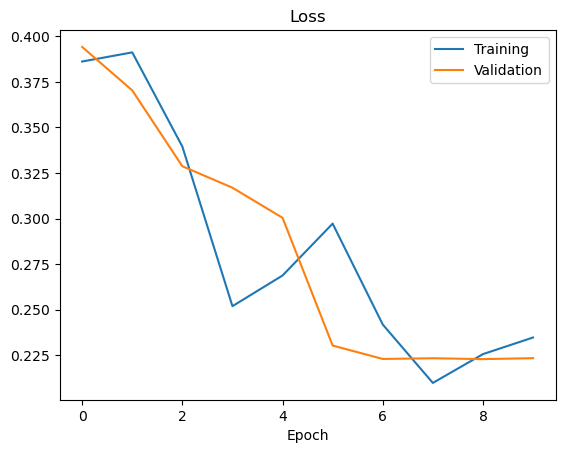

In [25]:
# results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [26]:
# Evaluate model
test_loss, test_mae, test_mse = model.evaluate(validation_generator, steps=len(xVal) // batch_data_size)
# test_loss, test_accuracy = model.evaluate(validation_generator, steps=len(xVal) // batch_data_size)
print(f'Test Loss: {test_loss}')
print(f'Test mae: {test_mae}')
print(f'Test mae: {test_mse}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2241 - mae: 0.4338 - mse: 0.2241
Test Loss: 0.22500623762607574
Test mae: 0.4318369925022125
Test mae: 0.22500623762607574


In [27]:

for j in range(20, 30):
    images_path_0 = data_frame.iloc[j]['images_path']
    steering_0 = data_frame.iloc[j]['steering']
    steering_forward_0 = data_frame.iloc[j]['steering_forward']
    steering_left_0 = data_frame.iloc[j]['steering_left']
    steering_right_0 = data_frame.iloc[j]['steering_right']

    prediction = test_model(model, images_path_0, steering_0,
                            steering_forward_0, steering_left_0, steering_right_0)
    print(f'image {images_path_0} Recorded vs Prediction : {steering_0} : {prediction}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Prediction for the test image: [[0.31033683]]
image data_collected/IMG10/Image_1716802457515725.jpg Recorded vs Prediction : left : left
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for the test image: [[0.3069854]]
image data_collected/IMG10/Image_1716802462668532.jpg Recorded vs Prediction : forward : left
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction for the test image: [[0.29993114]]
image data_collected/IMG10/Image_1716802464733857.jpg Recorded vs Prediction : forward : left
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Prediction for the test image: [[0.32642403]]
image data_collected/IMG10/Image_1716802466795475.jpg Recorded vs Prediction : left : left
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Prediction for the test image: [[0.35531276]]
image data_collected/IMG10/Image_1716802473005249.jpg Recorded vs Prediction : left : forward
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction for the test image: [[0.312504]]
image data_collected/IMG10/Image_1

In [28]:
# # Define a representative dataset function for quantization
# def representative_data_gen():
#     for input_value in validation_generator.take(100):  # Take a subset of your validation data
#         # The inputs should be in the same shape as expected by the model
#         yield [input_value[0]['image_input'].astype(np.float32), input_value[0]['numerical_input'].astype(np.float32)]


# saved_model = tf.keras.models.load_model('model.keras')

# converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_data_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.uint8  # or tf.float32
# converter.inference_output_type = tf.uint8  # or tf.float32

# tflite_model = converter.convert()

# # Save the quantized model to a file
# with open('model_quantized.tflite', 'wb') as f:
#     f.write(tflite_model)

# print("Quantized model saved as model_quantized.tflite")